# Master PCS - Out of Equilibrium statistical physics
## Homework problem
### __Simulating lattice model of surface groth__
Joseph Touzet

In [1]:
import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

We first implement the two deposition model: RDR and SOS.

In [2]:
def gen_starting_state(L):
    return np.zeros(L)

def gen_starting_states(L, n):
    return np.zeros((n, L))

In [3]:
def step_RDR(h):
    L = len(h)
    
    idx = np.random.randint(0, L)
    idx_left  = (idx-1+L)%L
    idx_right = (idx+1  )%L
    
    if  h[idx_left]  < h[idx_right]:
        h[idx_left]  += 1
    elif h[idx_left] > h[idx_right]:
        h[idx_right] += 1
    else:
        if np.random.rand() < 0.5:
            h[idx_left]  += 1
        else:
            h[idx_right] += 1
    
    return h

def simulate_RDR(h, t):
    for i in range(int(t)):
        h = step_RDR(h)
    return h

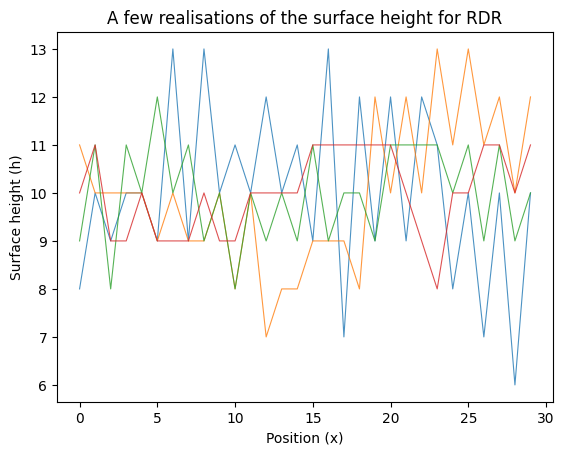

In [4]:
states = gen_starting_states(30, 4)
for i in range(states.shape[0]):
    states[i, :] = simulate_RDR(states[i, :], states.shape[1]*10)

plt.plot(states.T, alpha=0.8, linewidth=0.8)

plt.xlabel("Position (x)")
plt.ylabel("Surface height (h)")
plt.title("A few realisations of the surface height for RDR")
plt.show()

We can see by cheaking the possible surface heights that the algorithm seems to be working ("pixel" seperated by a single "pixel" are often at similar height).

In [5]:
def step_SOS(h):
    L = len(h)
    
    idx = np.random.randint(0, L)
    idx_left  = (idx-1+L)%L
    idx_right = (idx+1  )%L

    if abs(h[idx_left] - (h[idx]+1)) <= 1 and abs((h[idx]+1) - h[idx_right]) <= 1:
        h[idx] += 1
    
    return h

def simulate_SOS(h, t):
    for i in range(int(t)):
        h = step_SOS(h)
    return h

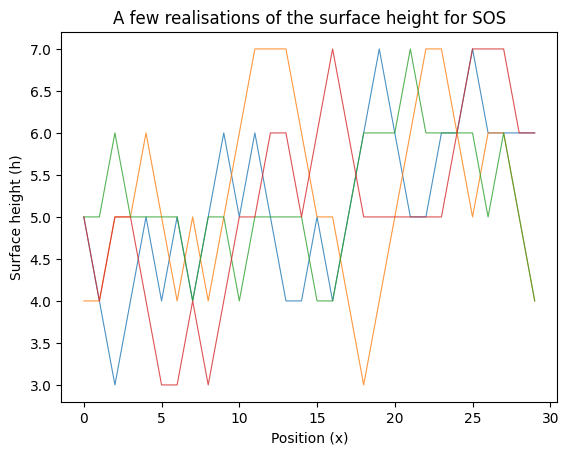

In [6]:
states = gen_starting_states(30, 4)
for i in range(states.shape[0]):
    states[i, :] = simulate_SOS(states[i, :], states.shape[1]*10)

plt.plot(states.T, alpha=0.8, linewidth=0.8)

plt.xlabel("Position (x)")
plt.ylabel("Surface height (h)")
plt.title("A few realisations of the surface height for SOS")
plt.show()

We can see that the gradients never goes above one, thus showing the deposition algorithm to be working.

We also need to implement a function to compute the roughness:

We first note that $W(L, t)^2 = \left< \overline{(h - \overline{h})^2} \right> = \left< std(h) \right> $

In [7]:
def compute_Wsqr_single(h):
    return np.std(h)

def compute_W(L, ts, simulator, n_it):
    Wsqr = np.zeros(len(ts))

    # for n_it strating graphs:
    for n in range(int(n_it)):
        h = gen_starting_state(L)

        # for all times ts:
        for i in range(len(ts)):
            # iterate the right amount of iteration to have a total of ts[i] iterations
            t = ts[i] - (0 if i == 0 else ts[i-1])    
            h = simulator(h, t)

            # accumulate the roughness
            Wsqr[i] += compute_Wsqr_single(h)

    # and copute the final average roughness:
    Wsqr_avg = Wsqr / n_it
    W = np.sqrt(Wsqr_avg)
    
    return W

def compute_W_RDR(L, ts, n_it):
    return compute_W(L, ts, simulate_RDR, n_it)
    
def compute_W_SOS(L, ts, n_it):
    return compute_W(L, ts, simulate_SOS, n_it)

Then, we need to implement a function to compute the probability of deviation of $h_i$ around $\overline{h}$:

In [8]:
def compute_deviation_probability(L, ts, simulator, n_it, dev_lim):
    dev = np.zeros((len(ts), 2*dev_lim+1))
    
    # for n_it strating graphs:
    for n in range(int(n_it)):
        h = gen_starting_state(L)
        
        # for all times ts:
        for i in range(len(ts)):
            # iterate the right amount of iteration to have a total of ts[i] iterations
            t = ts[i] - (0 if i == 0 else ts[i-1])    
            h = simulator(h, t)

            # accumulate the number of occurences for each deviation (dev in [[-dev_lim, +dev_lim]] )
            avg_h = int(np.round(np.mean(h)))
            for j in range(-dev_lim, dev_lim+1):
                dev[i,dev_lim+j] += np.mean(h == avg_h+j)

    # compute the probability:
    dev = dev / n_it
    return dev

def compute_deviation_probability_RDR(L, ts, n_it, dev_lim):
    return compute_deviation_probability(L, ts, simulate_RDR, n_it, dev_lim)
    
def compute_deviation_probability_SOS(L, ts, n_it, dev_lim):
    return compute_deviation_probability(L, ts, simulate_SOS, n_it, dev_lim)

And finally a function to fit data to a gaussian:

In [9]:
def fit_gaussian(x, y):
    def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

    mean  = np.mean(x*y)
    sigma = np.mean(y*(x - mean)**2)
    
    (a, x0, sigma),_ = opt.curve_fit(gaus,x,y,p0=[1,mean,sigma])
    
    return a, x0, abs(sigma)

## (1) - Long time roughness (W) evolution:
### a - For RDR:

In [10]:
Ls, n_it   = [10, 20, 50, 100], 300
taus       = [20, 40, 80, 150]
ts_over_L = np.round((np.linspace(1, 30, 40))**2)

In [11]:
W_RDR = [compute_W_RDR(L, L*ts_over_L, n_it) for L in Ls]

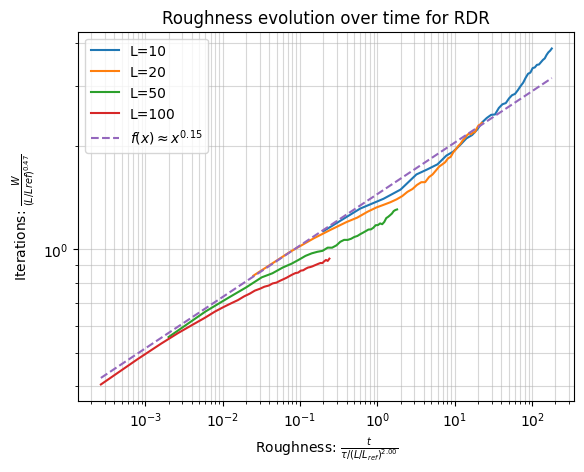

In [12]:
# parameters for the Family-Vicsek scaling
alpha, beta, z = 0.47, 0.15, 2

for i,(L,tau) in enumerate(zip(Ls, taus)):
    Mref = L/20
    plt.plot(ts_over_L/Mref**z/tau, W_RDR[i]/Mref**alpha, "-", label=f"L={L}")

x = np.linspace(ts_over_L[0]/(Ls[-1]/20)**z/taus[-1], ts_over_L[-1]/(Ls[0]/20)**z/taus[0], 100)
plt.plot(x, x**beta*1.45, "--", label=r"$f(x) \approx x^{%.2f}$"%(beta))

plt.title("Roughness evolution over time for RDR")

plt.xlabel(r"Roughness: $\frac{t}{\tau / (L/L_{ref})^{%.2f}}$"%(z))
plt.ylabel(r"Iterations: $\frac{W}{(L/Lref)^{%.2f}}$"%(alpha))

plt.xscale("log")
plt.yscale("log")
plt.grid("on", which='both', alpha=0.5, clip_on=True)

plt.legend()
plt.show()

### b - Long time roughness evolution for SOS:

In [13]:
W_SOS = [compute_W_SOS(L, L*ts_over_L, n_it) for L in Ls]

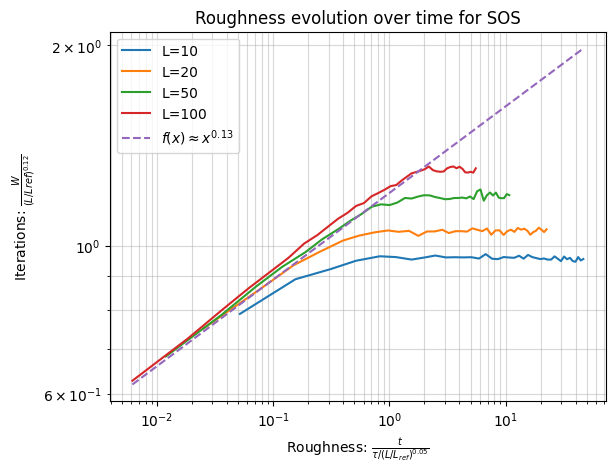

In [14]:
# parameters for the Family-Vicsek scaling
alpha, beta, z = 0.12, 0.13, 0.05

for i,(L,tau) in enumerate(zip(Ls, taus)):
    Mref = L/20
    plt.plot(ts_over_L/Mref**z/tau, W_SOS[i]/Mref**alpha, "-", label=f"L={L}")

x = np.linspace(ts_over_L[0]/(Ls[-1]/20)**z/taus[-1], ts_over_L[-1]/(Ls[0]/20)**z/taus[0], 10)
plt.plot(x, x**beta*1.2, "--", label=r"$f(x) \approx x^{%.2f}$"%(beta))

plt.title("Roughness evolution over time for SOS")

plt.xlabel(r"Roughness: $\frac{t}{\tau / (L/L_{ref})^{%.2f}}$"%(z))
plt.ylabel(r"Iterations: $\frac{W}{(L/Lref)^{%.2f}}$"%(alpha))

plt.xscale("log")
plt.yscale("log")
plt.grid("on", which='both', alpha=0.5, clip_on=True)

plt.legend()
plt.show()

For both models we see an acordance to the expected scaling for the given parameters. For the SOS model we eventualy reach a plateau, which can be explained by the limitation of the local gradient, which imposes a final number of possible interface configuration, which once reached to equilibrium (typically when the average height is L/2, the gradient limitation makes the h=0 limit irrelevent) just grows outsides without variation in the roughness.

## (2-3): Short time roughness evolution:

We can now find the small time exponent of the roughness $W = t^\beta$:

In [15]:
L, n_it  = 500, 400
ts_small = np.linspace(1,L)

In [16]:
W_RDR_small = compute_W_RDR(L, ts_small, n_it)

In [17]:
W_SOS_small = compute_W_SOS(L, ts_small, n_it)

In [18]:
a_RDR, b_RDR = np.polyfit(np.log(ts_small[:6]), np.log(W_RDR_small[:6]), 1)
a_SOS, b_SOS = np.polyfit(np.log(ts_small[:6]), np.log(W_SOS_small[:6]), 1)

For RDR beta=0.243
For SOS beta=0.24


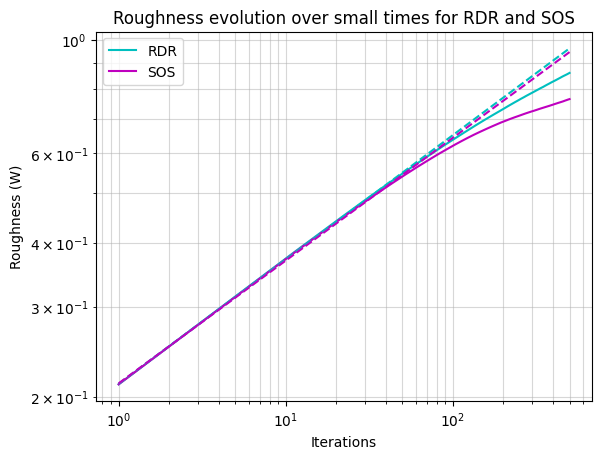

In [19]:
print(f"For RDR beta={ round(a_RDR, 3) }")
print(f"For SOS beta={ round(a_SOS, 3) }")

plt.plot(ts_small, W_RDR_small, "c-", label="RDR")
plt.plot(ts_small, W_SOS_small, "m-", label="SOS")

plt.plot(ts_small, np.exp(b_RDR)*(ts_small**a_RDR), "c--")
plt.plot(ts_small, np.exp(b_SOS)*(ts_small**a_SOS), "m--")

plt.xlabel("Iterations")
plt.ylabel("Roughness (W)")
plt.title("Roughness evolution over small times for RDR and SOS")
plt.xscale("log")
plt.yscale("log")
plt.grid('on', which='both', alpha=0.5, clip_on=True)

plt.legend()
plt.show()

(3) We get $\beta \approx 1/4$, thus both models are in the equivalence class of interface models.

## (4) - Deviation from the average:

We can now study the distribution around the average height for both models:

In [20]:
L, n_it = 300, 100
ts      = np.round(L*(np.linspace(2,30,5))**2)
max_dev = 15

### a - Deviation from the average for the RDR model:

In [21]:
dev_proba_RDR = compute_deviation_probability_RDR(L, ts, n_it, max_dev)

/home/joseph/.local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


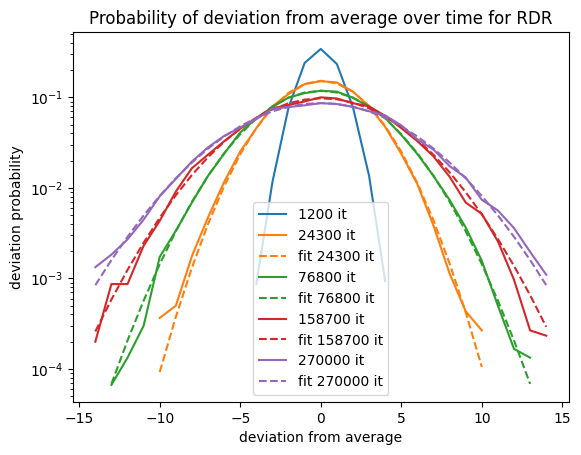

In [22]:
x = np.arange(-max_dev, max_dev+1)
sigmas_RDR = []

for i,(data,t) in enumerate(zip(dev_proba_RDR,ts)):
    dev_lim = np.max([abs(dev) for dev in x if data[max_dev+dev] > 0]) - 1
    idx_mask = np.arange(max_dev-dev_lim, max_dev+dev_lim+1)
    
    c = plt.plot(x[idx_mask], data[idx_mask], "-", label=f"{int(t)} it")[0].get_color()

    if i >= 1:
        a, x0, sigma = fit_gaussian(x[idx_mask], data[idx_mask])
        sigmas_RDR.append(sigma)
        
        plt.plot(x[idx_mask],
                 a*np.exp(-(x[idx_mask] - x0)**2/(2*sigma**2)),
                 "--", color=c, label=f"fit {int(t)} it")

plt.xlabel("deviation from average")
plt.ylabel("deviation probability")
plt.title("Probability of deviation from average over time for RDR")
plt.legend()
plt.yscale("log")
plt.show()

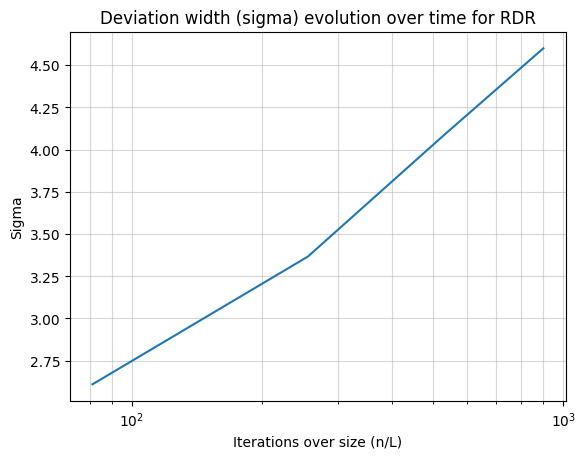

In [23]:
plt.plot(ts[1:]/L, sigmas_RDR)

plt.xlabel("Iterations over size (n/L)")
plt.ylabel("Sigma")
plt.title("Deviation width (sigma) evolution over time for RDR")

plt.xscale("log")
plt.grid("on", which='both', alpha=0.5, clip_on=True)

### b - Deviation from the average for the SOS model:

In [24]:
dev_proba_SOS = compute_deviation_probability_SOS(L, ts, n_it, max_dev)

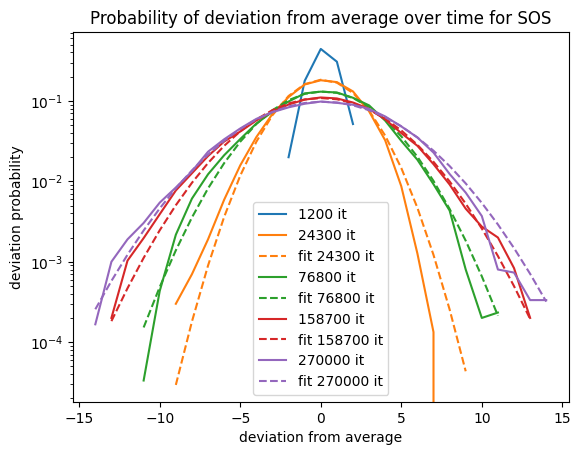

In [25]:
x = np.arange(-max_dev, max_dev+1)
sigmas_SOS = []

for i,(data,t) in enumerate(zip(dev_proba_SOS,ts)):
    dev_lim = np.max([abs(dev) for dev in x if data[max_dev+dev] > 0]) - 1
    idx_mask = np.arange(max_dev-dev_lim, max_dev+dev_lim+1)
    
    c = plt.plot(x[idx_mask], data[idx_mask], "-", label=f"{int(t)} it")[0].get_color()

    if i >= 1:
        a, x0, sigma = fit_gaussian(x[idx_mask], data[idx_mask])
        sigmas_SOS.append(sigma)
        
        plt.plot(x[idx_mask],
                 a*np.exp(-(x[idx_mask] - x0)**2/(2*sigma**2)),
                 "--", color=c, label=f"fit {int(t)} it")

plt.xlabel("deviation from average")
plt.ylabel("deviation probability")
plt.title("Probability of deviation from average over time for SOS")
plt.legend()
plt.yscale("log")
plt.show()

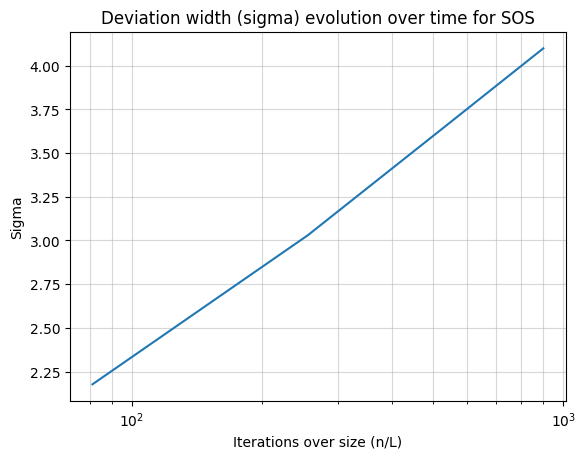

In [26]:
plt.plot(ts[1:]/L, sigmas_SOS)

plt.xlabel("Iterations over size (n/L)")
plt.ylabel("Sigma")
plt.title("Deviation width (sigma) evolution over time for SOS")

plt.xscale("log")
plt.grid("on", which='both', alpha=0.5, clip_on=True)

We see that for both models, at high time the deviation around the average is gaussian, and is flattening for larger times.

For SOS we however excpect a plateau in this standard deviation, which we were here not able to reach in a reasonable time.